<a href="https://colab.research.google.com/github/pinilDissanayaka/Facial-Expression-Recognition/blob/main/Notebook/Facial_Expression_Recognition3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install livelossplot
!pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 6.6 MB/s eta 0:00:00


In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2 as cv
from glob import glob

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import plot_model
from livelossplot import PlotLossesKerasTF
import visualkeras

%matplotlib inline

import warnings
warnings.filterwarnings(action = 'ignore')

In [6]:
import tensorflow
print("Tensorflow version:", tensorflow.__version__)

Tensorflow version: 2.14.0


In [7]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [8]:
! kaggle datasets download mahmoudima/mma-facial-expression

 86% 142M/166M [00:01<00:00, 117MB/s]
100% 166M/166M [00:01<00:00, 117MB/s]


In [9]:
! unzip /content/mma-facial-expression.zip

Streaming output truncated to the last 5000 lines.
  inflating: MMAFEDB/valid/neutral/8867Exp6fighting_expression_295.jpg  
  inflating: MMAFEDB/valid/neutral/8870Exp6fighting_expression_308.jpg  
  inflating: MMAFEDB/valid/neutral/8871Exp6fighting_expression_308.jpg  
  inflating: MMAFEDB/valid/neutral/8872Exp6fighting_expression_320.jpg  
  inflating: MMAFEDB/valid/neutral/8873Exp6fighting_expression_326.jpg  
  inflating: MMAFEDB/valid/neutral/8875Exp6fighting_expression_342.jpg  
  inflating: MMAFEDB/valid/neutral/8876Exp6fighting_expression_346.jpg  
  inflating: MMAFEDB/valid/neutral/8878Exp6fighting_expression_395.jpg  
  inflating: MMAFEDB/valid/neutral/8880Exp6fighting_expression_413.jpg  
  inflating: MMAFEDB/valid/neutral/8881Exp6fighting_expression_45.jpg  
  inflating: MMAFEDB/valid/neutral/8882Exp6fighting_expression_46.jpg  
  inflating: MMAFEDB/valid/neutral/8887Exp6fighting_expression_578.jpg  
  inflating: MMAFEDB/valid/neutral/8888Exp6fighting_expression_58.jpg  
  i

In [10]:
TRAIN_DIR = '/content/MMAFEDB/train'
TEST_DIR = '/content/MMAFEDB/test'
VALID_DIR = '/content/MMAFEDB/valid'

In [11]:
train_labels = (os.listdir(TRAIN_DIR))
test_labels = (os.listdir(TEST_DIR))
valid_labels = (os.listdir(VALID_DIR))

In [12]:
print(f"Train labels = {train_labels}")
print(f"Test labels = {test_labels}")
print(f"VAlidation labels = {valid_labels}")

Train labels = ['fear', 'surprise', 'sad', 'happy', 'neutral', 'disgust', 'angry']
Test labels = ['fear', 'surprise', 'sad', 'happy', 'neutral', 'disgust', 'angry']
VAlidation labels = ['fear', 'surprise', 'sad', 'happy', 'neutral', 'disgust', 'angry']


In [13]:
train_labels == test_labels == valid_labels

True

In [14]:
train_img_paths = glob(TRAIN_DIR + '/*/*')
test_img_paths = glob(TEST_DIR + '/*/*')
valid_img_paths = glob(VALID_DIR + '/*/*')

In [15]:
train_imgs = len(train_img_paths)
test_imgs = len(test_img_paths)
valid_imgs = len(valid_img_paths)

In [16]:
print(f"For train purpose we have {train_imgs} images")
print(f"For test purpose we have {test_imgs} images")
print(f"For valid purpose we have {valid_imgs} images")

For train purpose we have 92968 images
For test purpose we have 17356 images
For valid purpose we have 17356 images


In [17]:
train_img_shapes = set()
test_img_shapes = set()
valid_img_shapes = set()

for i in train_img_paths:
  img = cv.imread(i)
  img_shape = img.shape
  train_img_shapes.add(img_shape)


for i in test_img_paths:
  img = cv.imread(i)
  img_shape = img.shape
  test_img_shapes.add(img_shape)


for i in valid_img_paths:
  img = cv.imread(i)
  img_shape = img.shape
  valid_img_shapes.add(img_shape)

In [18]:
print(f"Train image size : {train_img_shapes}")
print(f"Test image size : {test_img_shapes}")
print(f"Validation image size : {valid_img_shapes}")

Train image size : {(48, 48, 3)}
Test image size : {(48, 48, 3)}
Validation image size : {(48, 48, 3)}


In [19]:
IMG_SIZE = [48, 48, 1]
OUT_SIZE = len(train_labels)
print(f"Input sahpe = {IMG_SIZE}")
print(f"Output shape = {OUT_SIZE}")

Input sahpe = [48, 48, 1]
Output shape = 7


In [21]:
train_gen = ImageDataGenerator(rotation_range=0.9,
                              rescale= 1./255,
                              horizontal_flip= True,
                              width_shift_range=0.5,
                              height_shift_range=0.6,
                              shear_range=0.5,
                              zoom_range=0.8)

valid_gen = ImageDataGenerator(rescale= 1./255)


test_gen = ImageDataGenerator(rotation_range=0.9,
                              rescale= 1./255,
                              horizontal_flip= True,
                              width_shift_range=0.5,
                              height_shift_range=0.6,
                              shear_range=0.5,
                              zoom_range=0.8)

In [22]:
train_df = train_gen.flow_from_directory(TRAIN_DIR,
                                            target_size=(48, 48),
                                            batch_size=32,
                                            color_mode='grayscale',
                                            class_mode='categorical',
                                            shuffle=True)

valid_df = valid_gen.flow_from_directory(VALID_DIR,
                                        target_size=(48, 48),
                                        batch_size=32,
                                        color_mode='grayscale',
                                        class_mode='categorical',
                                         shuffle=True)

test_df = test_gen.flow_from_directory(TEST_DIR,
                                      target_size=(48, 48),
                                      batch_size=32,
                                      color_mode='grayscale',
                                      class_mode='categorical',
                                      shuffle=True)

Found 92968 images belonging to 7 classes.
Found 17356 images belonging to 7 classes.
Found 17356 images belonging to 7 classes.


In [24]:
train_df

In [25]:
train_df.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [26]:
train_steps = train_df.n // train_df.batch_size
valid_steps = valid_df.n // valid_df.batch_size

In [27]:
model = Sequential()

model.add(Conv2D(filters= 32, kernel_size= (3, 3), strides= 1, padding= 'same', activation= 'relu', input_shape = IMG_SIZE))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size= (2, 2), padding='same'))
model.add(Dropout(0.2))

model.add(Conv2D(filters= 64, kernel_size= (5, 5), strides= 1, padding= 'same', activation= 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size= (2, 2), padding='same'))
model.add(Dropout(0.2))

model.add(Conv2D(filters= 128, kernel_size= (3, 3), strides= 1, padding= 'same', activation= 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size= (2, 2), padding='same'))
model.add(Dropout(0.3))

model.add(Conv2D(filters= 256, kernel_size= (5, 5), strides= 1, padding= 'same', activation= 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size= (2, 2), padding='same'))
model.add(Dropout(0.2))

model.add(Conv2D(filters= 512, kernel_size= (3, 3), strides= 1, padding= 'same', activation= 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size= (2, 2), padding='same'))
model.add(Dropout(0.3))


model.add(Flatten())
model.add(Dense(units= 1024, activation= 'relu'))
model.add(Dense(units= OUT_SIZE, activation= 'softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 batch_normalization (Batch  (None, 48, 48, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        51264     
                                                                 
 batch_normalization_1 (Bat  (None, 24, 24, 64)        2

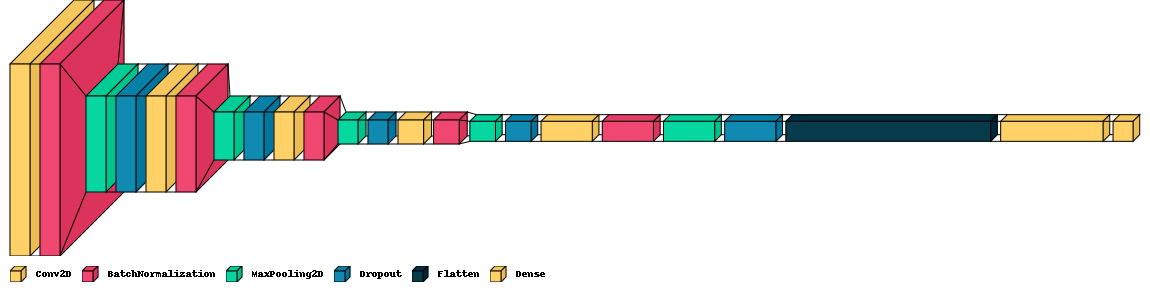

In [28]:
visualkeras.layered_view(model, legend=True)

In [31]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [33]:
early_stopping = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.1,
                              patience=2,
                              min_lr=0.00001,
                              model='auto')

callbacks = [reduce_lr, PlotLossesKerasTF(), early_stopping]

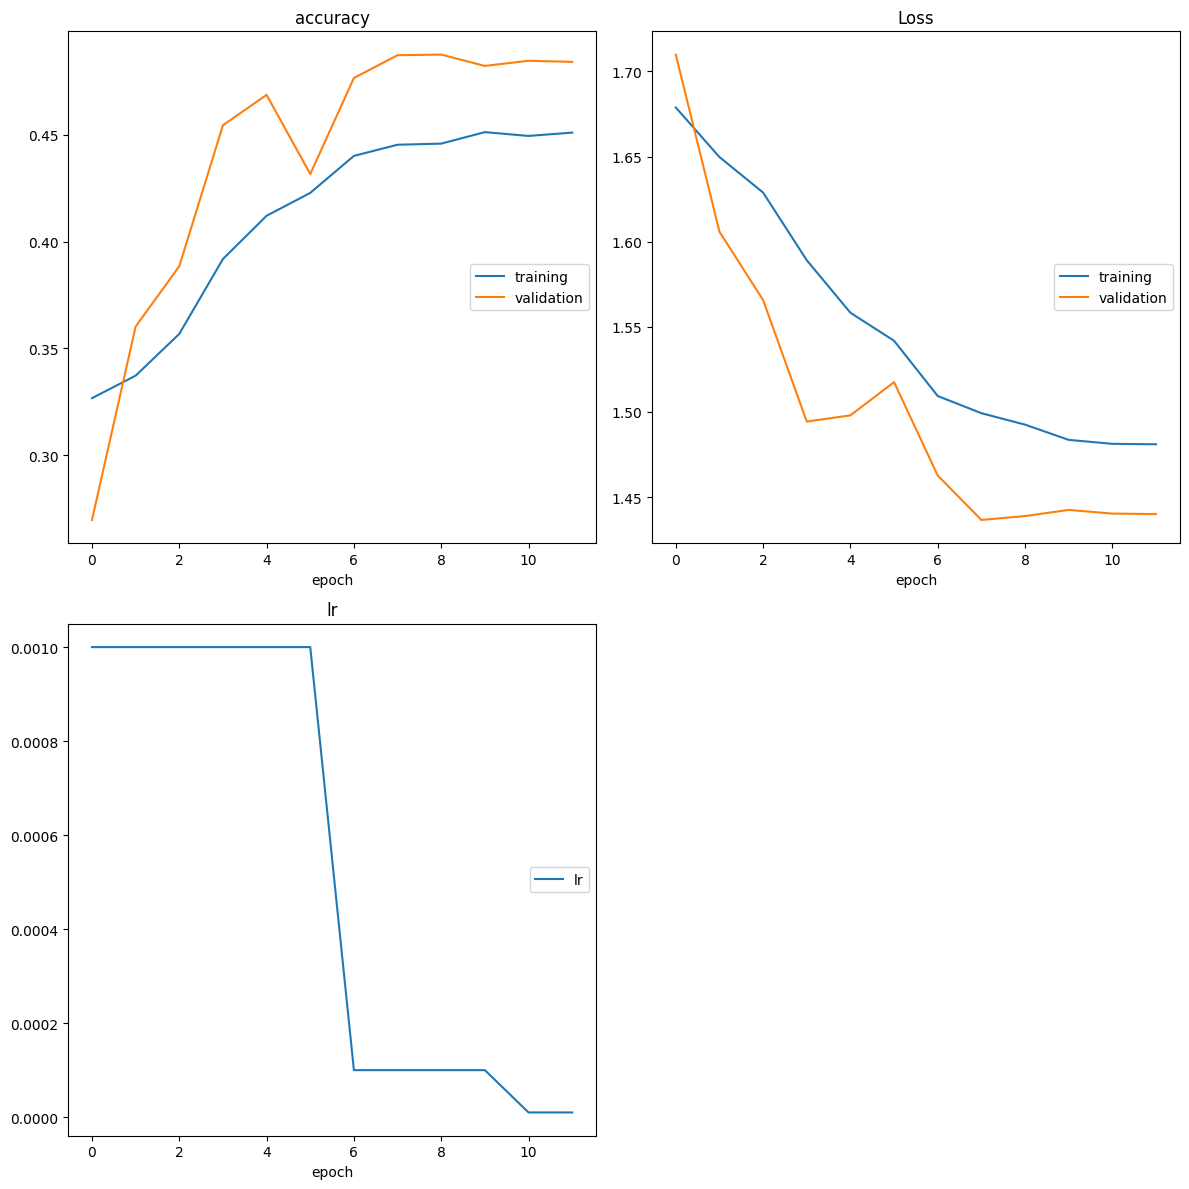

accuracy
	training         	 (min:    0.327, max:    0.451, cur:    0.451)
	validation       	 (min:    0.270, max:    0.488, cur:    0.484)
Loss
	training         	 (min:    1.481, max:    1.679, cur:    1.481)
	validation       	 (min:    1.437, max:    1.710, cur:    1.440)
lr
	lr               	 (min:    0.000, max:    0.001, cur:    0.000)
2905/2905 [==============================] - 114s 39ms/step - loss: 1.4810 - accuracy: 0.4511 - val_loss: 1.4401 - val_accuracy: 0.4842 - lr: 1.0000e-05


In [34]:
model.fit_generator(train_df,
                    steps_per_epoch= train_steps,
                    epochs = 12,
                    verbose = 1,
                    callbacks=callbacks,
                    validation_data=valid_df,
                    validation_steps= valid_steps)